## CLV and Lifespan Estimates

In this notebook, we're going to leverage the **lifetimes** package to deep dive into customer value and churn for a eCommerce client that sells widgets.  The workbook is broken down into the following components:

#### Summary

- [Setup](#Setup)
- [1. Data Exploration](#1.-Data-Exploration)
 - [DataFrame Setup](#Dataframe-Setup)
 - [Model Construction](#Model-Construction)
- [2. Top Customers by Transactions](#2.-Top-Customers-by-Transactions)
- [3. Top Customers by Spend](#3.-Top-Customers-by-Spend)
- [4. Assumptions](#4.-Assumptions)
- [5. Simulation](#5.-Simulation)
- [6-8. Additional Questions](#Questions-6-through-8)

For much of this workbook we'll be leveraging the existing documentation which can be found here: 
https://readthedocs.org/projects/lifetimes/downloads/pdf/latest/

#### Setup

In [77]:
#import relevant libraries
import pandas as pd
import lifetimes
import seaborn as sns
import matplotlib.pyplot as plt
import lifetimes

from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes import GammaGammaFitter,ModifiedBetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix,  plot_calibration_purchases_vs_holdout_purchases,plot_history_alive


In [78]:
#read in our file
df = pd.read_csv('data.csv')

### 1. Data Exploration
[Return to Summary](#Summary)

#### Dataframe Setup

As with any dataset we're given, we'll want to do some quick initial exploration of datatypes and check for any NaNs that may require imputation.

In [79]:
#check datatypes for our features
df.dtypes

CustomerID        object
Timestamp         object
PurchaseValue    float64
dtype: object

We notice that our *timestamp* column is of type 'object' -- to be safe, we'll convert this to 'datetime.' The **lifetimes** package requires that a period of time be designated prior to model instantiation. Here, we'll be using day granularity. 

In [80]:
#grab our timestamp column and convert to datetime. Truncate to include only 'day'
df.Timestamp = pd.to_datetime(df.Timestamp)
df.Timestamp = df.Timestamp.dt.date

In [81]:
#confirm changes are in place
df.dtypes

CustomerID        object
Timestamp         object
PurchaseValue    float64
dtype: object

In [82]:
#get a sense for how many customers we are dealing with relative to our transactions (23.7K, ~50K respectively)
len(df.CustomerID.unique()), len(df)

(23708, 49945)

When we fit our model, it will also be important to create a holdout group to understand it's accuracy. This package allows us to create a holdout based on date thresholds, so it benefits us to get a sense of date ranges now before moving forward:

In [83]:
#check oldest dates
df.Timestamp.sort_values().head()

37874    2016-11-30
17643    2016-11-30
17613    2016-11-30
34015    2016-11-30
17600    2016-11-30
Name: Timestamp, dtype: object

In [84]:
#Check newest dates
df.Timestamp.sort_values().tail()

5495     2017-12-06
47129    2017-12-06
13722    2017-12-06
35653    2017-12-06
32307    2017-12-06
Name: Timestamp, dtype: object

Finally, we check for NaNs and determine that there is no imputation needed for our data set.

In [85]:
#count NaNs
df.isnull().sum()

CustomerID       0
Timestamp        0
PurchaseValue    0
dtype: int64

The **lifetimes** package operates with a dataframe of the following fields. While the last field is not explicitly needed in the case of churn analysis, it does come into play with respect to CLV and the Gamma Gamma submodel.

- **Frequency**: Repeat purchases made by our customer

- **Recency**: Age of customer when they made their most recent purchase

- **Customer Age (T)**: The difference between date of first purchase and our most recent/cutoff date, in whatever units are selected

- **Monetary Value**: The average value (revenue, profit, or other depending on inputs to model) of a customer.


In [86]:
#leverage pre-existing method to build out dataframe
data = summary_data_from_transaction_data(df, 'CustomerID', 'Timestamp', monetary_value_col='PurchaseValue')

#check it out
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280
00028502859fd7e111d88c20456b59d5,0.0,0.0,342.0,0.000
000306d200fd6e9b03de48d15348f5c2,0.0,0.0,33.0,0.000
0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065
000784b838b807ad589d4bc69c0c562f,0.0,0.0,210.0,0.000


#### Quick EDA

Before moving further, it may be interesting to get a sense of what our dataset look like. Here, we'll look at distributions of our features for repeat purchasers:

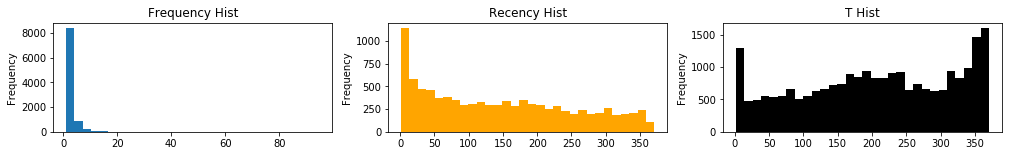

In [87]:
#Quickly chart the three features that were just constructed to assess distributions.
plt.figure(figsize = (17,2))
plt.subplot(1,3,1)
plt.title('Frequency Hist')
data[data['frequency'] > 0]['frequency'].plot(kind='hist', bins=30) #subplot 1
plt.subplot(1,3,2)
plt.title('Recency Hist')
data[data['recency'] > 0]['recency'].plot(kind='hist', bins=30, color='orange'); #subplot 2

plt.subplot(1,3,3)
plt.title('T Hist')
data[data['T'] > 0]['T'].plot(kind='hist', bins=30, color='black'); #subplot 2

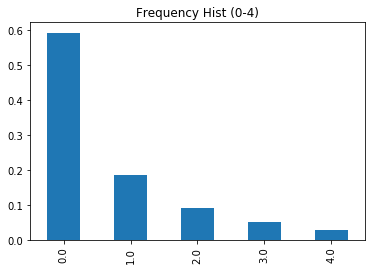

In [88]:
#Zoom in on our frequency distribution
data.frequency.value_counts(normalize=True).head(5).plot(kind='bar')
plt.title('Frequency Hist (0-4)');

In [89]:
#Take a look at the summary stats of our fields
data.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,23708.0,1.025477,2.111326,0.0,0.0,0.0,1.0000,95.0
recency,23708.0,58.355154,98.565275,0.0,0.0,0.0,86.0000,371.0
T,23708.0,204.519403,110.976868,0.0,117.0,209.0,307.0000,371.0
monetary_value,23708.0,94.028495,168.026439,0.0,0.0,0.0,146.7225,3420.7


Based on the data, we see the following:
 - A strong majority of users are not repeat purchases (~60%)
 - We also see a strong right skew with respect to Recency, which means that a majority of our transactions have occurred more recently
 - Finally, our **T** distribution which represent age of our customer, shows that we have a large number of new and very old customers (within our given observation timeframe)

#### Model Construction

Now we move into model fitting. **lifetimes** has several models that can be leveraged but here we'll be tapping into the MBG/NBD model. After fitting this model we'll pause to explore some of the results visually.

In [90]:
#fit our model. Depending on how our model performs against our holdout group later, we may consider revisiting our penalizer coefficient
mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0)
mbgnbd.fit(data['frequency'], data['recency'], data['T']);

the **Recency/Frefuency Matrix (RFM)** is a visual representation of our customers expected future transaction / probability of being alive relative to their corresponding frequency and recency.

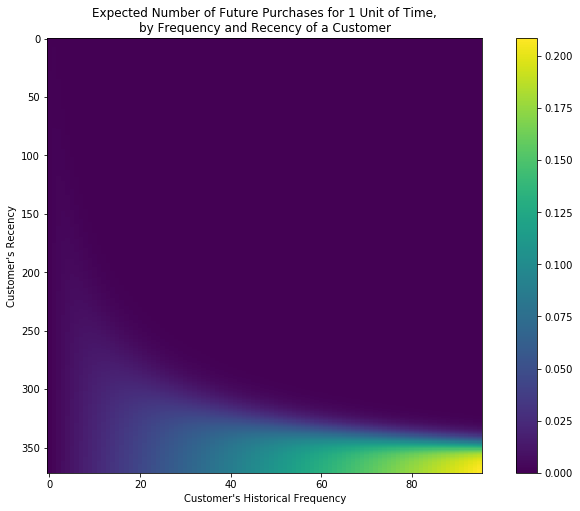

In [91]:
#plot our RFM for expected transactions
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(mbgnbd);

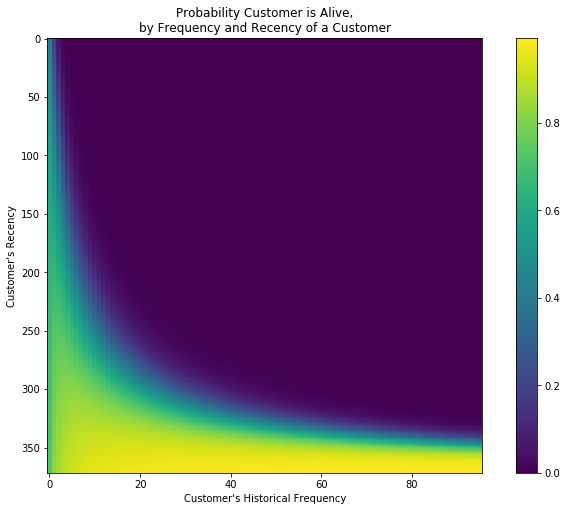

In [92]:
#plot our RFM for alive probability
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(mbgnbd);

A couple of quick observations based on these plots:
 - *Transactions*: Repeat purchases with gaps in time between first and most recent purchase are most likely to transact.
 - *Alive*: Recency is a significant driver of alive probability of being alive. If a customer is a frequent purchaser, but recency is low, their alive probability is also low. This makes intuitive sense -- if a user purchases a lot in a short period of time and then drops off the radar, we are unlikely to see them again.

#### Assess Model

The **lifetimes** package comes complete with several visualization methods to understand how our model matches our actuals. Here, we compare the frequency of repeat transactions by calibration period across our actuals and predicted datasets. Visually our bins align which is a good sign.

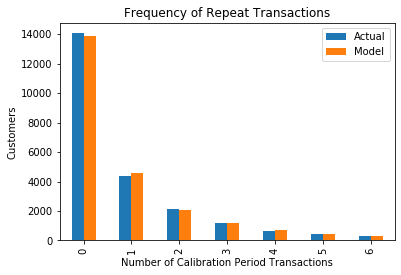

In [93]:
#plot model vs actuals for frequency of repeat transactions
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(mbgnbd);

As mentioned earlier, we can also assess the strength of our model by creating a holdout group. Here, we leverage one portion of our transaction data (up to 9/8/17) to train our model, while the remaining data (up to 12/6/17) is used for comparison. We'll look at frequency of repeat purchases across both sets.

In [94]:
#build our holdout group using disparate timeframes
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'Timestamp',
                                        calibration_period_end='2017-09-08',
                                        observation_period_end='2017-12-06' )   
print(summary_cal_holdout.head())


                                  frequency_cal  recency_cal  T_cal  \
CustomerID                                                            
0001117ff1305c1fe840697166e61564            1.0         11.0  255.0   
00028502859fd7e111d88c20456b59d5            0.0          0.0  253.0   
0003f3458a6e7b495a975c2d9ddda559            1.0          2.0  254.0   
000784b838b807ad589d4bc69c0c562f            0.0          0.0  121.0   
000ad0f90e9fcb6ff5a0bc480cccbdb3            5.0         68.0  111.0   

                                  frequency_holdout  duration_holdout  
CustomerID                                                             
0001117ff1305c1fe840697166e61564                0.0                89  
00028502859fd7e111d88c20456b59d5                0.0                89  
0003f3458a6e7b495a975c2d9ddda559                1.0                89  
000784b838b807ad589d4bc69c0c562f                0.0                89  
000ad0f90e9fcb6ff5a0bc480cccbdb3                0.0                89 

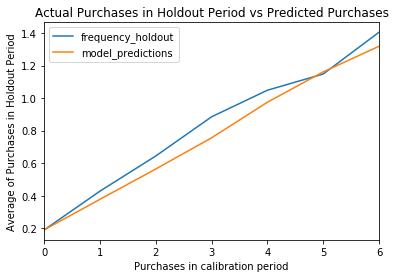

In [95]:
#how does our model compare with actuals with respect to purchase frequency across purchase periods
mbgnbd.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout);

The predicted purchases of our model appear to be in close alignment with our actuals.

### 2. Top Customers by Transactions
[Return to Summary](#Summary)

Our dataset is constructed with time periods equal to days. Let's look at our top 100 customers over 365 days:

In [96]:
#build in an additional column for predicted purchases over the courser of a year
data['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(365, data['frequency'], data['recency'], data['T'])

In [97]:
#print out our top purchasers
pd.set_option('display.max_rows', 100)
data.sort_values(by='predicted_purchases', ascending=False).head(100).apply(round)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
a5fadc51b1ae844ad9a70ad3cfa46a64,95.0,371.0,371.0,434.0,59.0
48a503edbaded96a3be27deee11967a1,46.0,363.0,371.0,220.0,28.0
9f447f9415a380ac2eeee7df49c6ee7e,23.0,163.0,166.0,110.0,23.0
5f01420f0edda6555df5ce1cc62b986c,39.0,350.0,370.0,299.0,22.0
8d2ce54737dd404d20cadf1405d46dc8,33.0,360.0,362.0,123.0,21.0
a62a17bb46864da2c6da691d838971b3,30.0,366.0,366.0,308.0,19.0
3b11478939967e896ae2619615650f97,20.0,190.0,194.0,59.0,18.0
2ad9a83ee23110d8c2f4c01600b94f20,29.0,357.0,364.0,146.0,18.0
75fda9ea22086bf3814ff8c3f53de8ca,28.0,348.0,355.0,196.0,18.0


We can grab our top customer by transaction volume and our bottom customer by transaction volume to assess their historical probability of being alive over time to validate. You can see that, in the case of our top customer, the transaction frequency and recency keeps his/her p_alive above 0.9 for the back half of 2017. In the case of our bottom customer, our pathway shows a history of semi-frequent purchasing that then petered out around April 2017-- his/her p_alive has diminished over time since. 

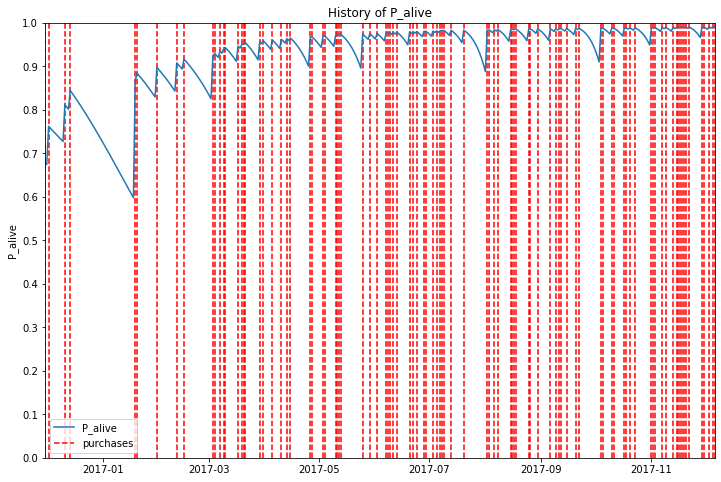

In [98]:
#grab top customer by expected transactions
person_trans = df[df.CustomerID == 'a5fadc51b1ae844ad9a70ad3cfa46a64']

#plot person p_alive history
fig = plt.figure(figsize=(12,8))
days_since_birth = 365
plot_history_alive(mbgnbd, days_since_birth, person_trans, 'Timestamp');

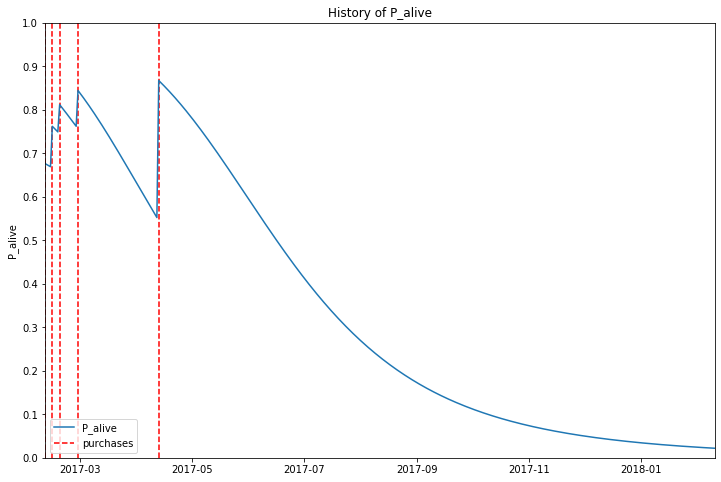

In [99]:
#grab bottom customer by expected transactions
person_trans_bad = df[df.CustomerID == 'eb6170789806f7ab6039c7f78a181bb2']

#plot person p_alive history
fig = plt.figure(figsize=(12,8))
days_since_birth = 365
plot_history_alive(mbgnbd, days_since_birth, person_trans_bad, 'Timestamp');

### 3. Top Customers by Spend
[Return to Summary](#Summary)

We can do the same thing with the anticipated spend of our customers leveraging the Gamma Gamma model:

In [100]:
#grab customers with repeat purchase history
return_customers = data[data['frequency']>0]

In [101]:
#fit gamma gamma model
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_customers['frequency'],
        return_customers['monetary_value']);

In [102]:
#grab CLVs and read into a dataframe
clv_df = pd.DataFrame(ggf.customer_lifetime_value(
    mbgnbd, #the model to use to predict the number of future transactions
    return_customers['frequency'],
    return_customers['recency'],
    return_customers['T'],
    return_customers['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
))

In [103]:
#combine these results back into our original dataframe
data = pd.merge(data, clv_df, how='inner', on='CustomerID')

In [104]:
#print out high CLV users
pd.set_option('display.max_rows', 100)
data.sort_values(by='clv', ascending=False).head(100).apply(round)

,frequency,recency,T,monetary_value,predicted_purchases,clv
CustomerID,,,,,,
a5fadc51b1ae844ad9a70ad3cfa46a64,95.0,371.0,371.0,434.0,59.0,23843.0
ca2202a96c2de6ca6b8a37a4a73fa730,7.0,12.0,20.0,1400.0,12.0,15282.0
dca76db00cc59dfbcdcc97c8bbc7f9f1,19.0,339.0,364.0,966.0,11.0,9810.0
5ac5ed64cd99ed2a8403b7a927e644ef,23.0,222.0,250.0,627.0,15.0,8404.0
60c19a709e3ced2d16d7100eb1069df5,10.0,292.0,300.0,1259.0,7.0,8136.0
5f01420f0edda6555df5ce1cc62b986c,39.0,350.0,370.0,299.0,22.0,6098.0
742d5a52d4df7cb14246d7f390de5d8a,21.0,340.0,356.0,506.0,13.0,6027.0
089ecc49200cfe79584d0bec2a3cf8c0,2.0,125.0,134.0,2937.0,3.0,5958.0
a719d6643a7832535de9aded2f467825,26.0,360.0,368.0,399.0,16.0,5936.0


### 4. Assumptions
[Return to Summary](#Summary)

**Assumption #1**: For a given user, transactions follow a Poisson Process.

 - Additional background and context for widgets would be helpful here. A Poisson Process relies on the following assumptions here: that a user's transaction rate is constant for a given time period; that transactions cannot occur at the same time; that one transaction does not impact the probability of another transaction. Depending on what a widget is and how it is used, seasonal interest in the product could influence transaction probabilities for certain parts of the year; multiple widgets may be purchased at once; a widget may be a high price item and infrequent purchase, meaning that if it is bought once, the likelihood of it being bought again may decline. 
 
**Assumption #2**: Customers only dropout ('die') at the point of transaction with probability X; the distribution of dropout probability is geometrically distributed.

 - The dropout PMF follows a geometric distribution, which in essence means that the probability of dropping out declines as transactions with the company increases. This is a fair assumption-- increasing number of purchases is a reflection of sustained loyalty / interest.
 
**Assumption #3**: With respect to the Gamma Gamma model, the assumption made is that there is no relationship between monetary value and the frequency of purchases for a given customer.

 - In the context of eCommerce, depending on the company, this assumption may not be valid. A user that purchases a variety of items, or stockpiles one item, as part of one transaction is probably not going to need to make another purchase as quickly as a user that makes a one-off purchase.

**Asumption #4**: Transaction and dropout probabilities vary independently across customers.
 
 - This is a fair assumption to make with some small exceptions. Users that can be considered part of the same household will influence transaction/dropout probabilities of one another. This is an edge case, however, and in practice may be a small representation of the overall customer pool. Resolving users to the household level could be one way to address this.
 
**Asumption #5**: An implicit assumption is made regarding treatment of customers. Marketing and retention efforts are assumed to remain the same over time.
 
 - Business are often evolving their marketing/retention efforts so this assumption is likely not valid in practice. 
 

### 5. Simulation

We want to simulate expected transactions and the number of alive customers for different timeframes. To supplement our predictions to include alive probabilities, I am fitting the BGBB model which allows us to pass through a future number of periods to return alive probabilities at the customer level based on transaction histories. We're going to assume that any customer with probability > 0.05 is considered alive, and those below this threshold are considered dead.

In [153]:
from lifetimes import BetaGeoBetaBinomFitter

#fit BGBB for alive probabilities
bgbb =  BetaGeoBetaBinomFitter(penalizer_coef=0.0)
bgbb.fit(data['frequency'], data['recency'], data['T']);

In [151]:
#instantiate relevant lists for our loop
timeframes = [10,365,3650, 36500]
est_purchases = []
est_alives =[]

#grab a random sample of 100 customers
randsamp = data.sample(100)

#for every timeframe, grab the expected number of purchases and the alive probabilities
for timeframe in timeframes:

        purchases = mbgnbd.conditional_expected_number_of_purchases_up_to_time(timeframe, randsamp['frequency'], randsamp['recency'], randsamp['T']).sum()
        est_purchases.append(purchases)
        
        
        
        probs_df = pd.DataFrame(bgbb.conditional_probability_alive(timeframe, randsamp['frequency'], randsamp['recency'], randsamp['T'])).rename(columns={0:'prob'})
        alive_count = probs_df[probs_df.prob> 0.05].count()[0]
        est_alives.append(alive_count)

pd.DataFrame({'Period (Days)':periods, 'Purchases':est_purchases, 'Alive Count':est_alives}).apply(round)

,Period (Days),Purchases,Alive Count
0,10,8.0,93
1,365,208.0,93
2,3650,848.0,93
3,36500,1943.0,93


### Other
[Return to Summary](#Summary)

What isn't working so well with our model?

 - Our model is effective when it comes to predicting purchase behavior, but doesn't align with our intuition with respect to alive probabilities. The model seems to assume no significant long term alive probability change at the customer level. We can take a look at a low p_alive user against our timeframes to demonstrate this. We can see that the probbility of this user being alive is 0.000397 after 10 days, and 0.000364 after 10 years. The difference is minimal.

In [180]:
#build a temporary dataframe to grab a customer
temp_bgbb_df = pd.DataFrame(bgbb.conditional_probability_alive(10, randsamp['frequency'], randsamp['recency'], randsamp['T'])).rename(columns={0:'prob'}).apply(lambda x: '%.5f' % x, axis=1)

#grab a sample low p_alive value customer
low_p_alive_customer= temp_bgbb_df.sort_values().head().index[2]

In [188]:
#track alive probabilities for a low p_alive customer
for timeframe in timeframes: 
    
    #print probs across our timeframes
    print(bgbb.conditional_probability_alive(timeframe, data[data.index == low_p_alive_customer]['frequency'], 
                                   data[data.index == low_p_alive_customer]['recency'],
                                   data[data.index == low_p_alive_customer]['T']))

CustomerID
1af78eda11ddf65a328380ce5f5980e0    0.000397
dtype: float64
CustomerID
1af78eda11ddf65a328380ce5f5980e0    0.000392
dtype: float64
CustomerID
1af78eda11ddf65a328380ce5f5980e0    0.000379
dtype: float64
CustomerID
1af78eda11ddf65a328380ce5f5980e0    0.000364
dtype: float64


How might we improve it?

 - Integrating a long term decay rate for alive probabillities, in particular for customers that are under a given threshold of p_alive given our current set of observed data, could help adjust for this.